# Symbol Detection

dataset: https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols

sample model: https://github.com/OdyAsh/Handwritten-M2L/blob/main/model.ipynb

In [1]:
import os

import cv2
import pickle
import numpy as np
from functools import cmp_to_key

from keras.src.layers import BatchNormalization
from keras.src.ops import shape
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from keras import ops   
import matplotlib.pyplot as plt

In [2]:
dic = {
    "-": r"-",
    "(": r"(",
    ")": r")",
    "+": r"+",
    "=": r"=",
    "times": r"\times",
    "0": r"0",
    "1": r"1",
    "2": r"2",
    "3": r"3",
    "4": r"4",
    "5": r"5",
    "6": r"6",
    "7": r"7",
    "8": r"8",
    "9": r"9",
    "div": r"\div", 
    "y": r"y", 
    "X": r"x", 
    "C": r"c", 
    "M": r"m"
}

In [ ]:
# set class size
class_size = 1000

# loads and splits data into imgs and labels 
# inputs: Data - directory where all the class folders are stored
#         Dic - dictionary of all the classes that are to be classified 
#
# outputs: imgs - 

def loadData(DataDir):
  imgs = []
  labels = []
  
  
  for k, v in dic.items():
    path = os.path.join(DataDir, k)
    c = 0 
    for imgName in os.listdir(path):
      try:
        img = cv2.imread(os.path.join(path, imgName), cv2.COLOR_BGR2GRAY)
        imgs.append(img)
        labels.append(v)
        
        c+=1
        if c>class_size:
            break

      except Exception as e:
        print(e)

  return imgs, labels


imgs, labels = loadData(r"D:\Work\Code\TopYear\HandMtoLat\input\extracted_images")



In [4]:

with open("x_symbols.pickle", 'wb') as f:
   pickle.dump(imgs, f)
with open("y_latex.pickle", 'wb') as f:
   pickle.dump(labels, f)

In [4]:

# Open the file in binary read mode
with open('x_symbols.pickle', 'rb') as file:
    # Deserialize the dataset object from the file
    imgs = pickle.load(file)
with open('y_latex.pickle', 'rb') as file:
    labels = pickle.load(file)

In [5]:
latexToNums = {k: v for v, k in enumerate(np.unique(labels))}
numsToLatex = {v: k for v, k in enumerate(np.unique(labels))}

In [6]:
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size = 0.33, stratify=labels, random_state=42)

In [7]:

input_shape = (45, 45, 1) 
num_classes = 32 

x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.33, stratify=labels, random_state=42)


y_train_nums = [latexToNums[latex] for latex in y_train]
y_test_nums = [latexToNums[latex] for latex in y_test]

# Convert data into np arrays
x_train = np.array(x_train)
x_test = np.array(x_test)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train_nums = [latexToNums[latex] for latex in y_train]
y_test_nums = [latexToNums[latex] for latex in y_test]

y_train_cat = keras.utils.to_categorical(y_train_nums, num_classes)
y_test_cat = keras.utils.to_categorical(y_test_nums, num_classes)

print("y_train_cat shape:", y_train_cat.shape)

x_train shape: (13994, 45, 45, 1)
13994 train samples
6894 test samples
y_train_cat shape: (13994, 32)


In [8]:
type(x_train), type(x_test), type(y_train_nums), type(y_test_nums)

(numpy.ndarray, numpy.ndarray, list, list)

In [9]:
model = keras.Sequential(
    
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 43, 43, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 19, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       165,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,736 (721.62 KB)

 Trainable params: 184,736 (721.62 KB)

 Non-trainable params: 0 (0.00 B)

\div


AttributeError: 'numpy.ndarray' object has no attribute 'expandd'

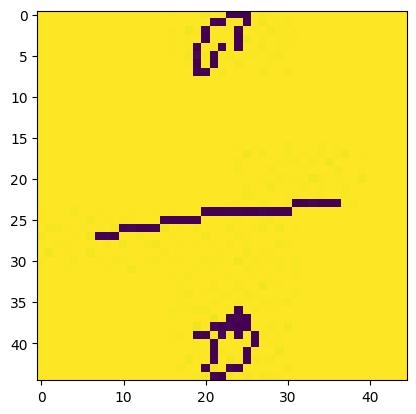

In [11]:
plt.imshow(x_test[0])
print(y_test[0])

print(model.predict(x_test[0].expandd))

In [12]:
batch_size = 128
epochs =15 

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

print(history.history.keys())

Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3420 - loss: 2.3529 - val_accuracy: 0.7643 - val_loss: 0.8061
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7795 - loss: 0.7759 - val_accuracy: 0.8400 - val_loss: 0.5730
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8454 - loss: 0.5390 - val_accuracy: 0.8764 - val_loss: 0.4355
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8761 - loss: 0.4095 - val_accuracy: 0.9000 - val_loss: 0.3468
Epoch 5/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9045 - loss: 0.3228 - val_accuracy: 0.9179 - val_loss: 0.3001
Epoch 6/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9179 - loss: 0.2765 - val_accuracy: 0.9093 - val_loss: 0.2988
Epoch 7/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9218 - loss: 0.2506 - val_accuracy: 0.9107 - val_loss: 0.2957
Epoch 8/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9306 - loss: 0.2213 - val_accuracy: 0.9221 - v

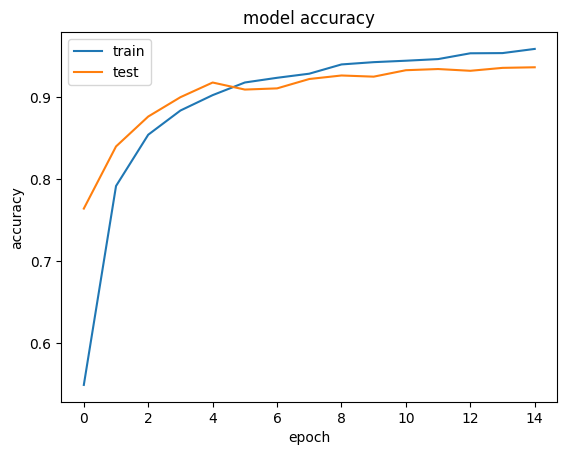

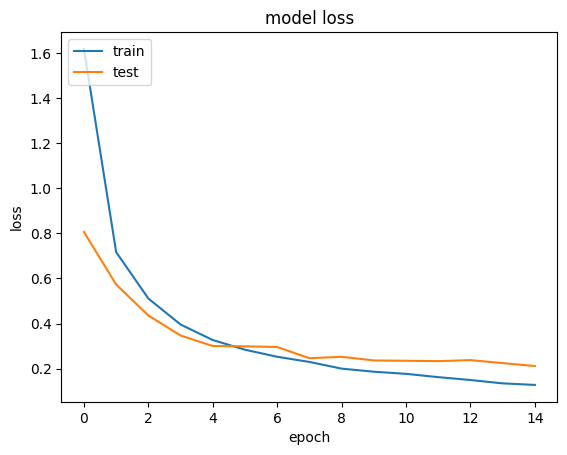

In [13]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

<Figure size 1000x1000 with 0 Axes>

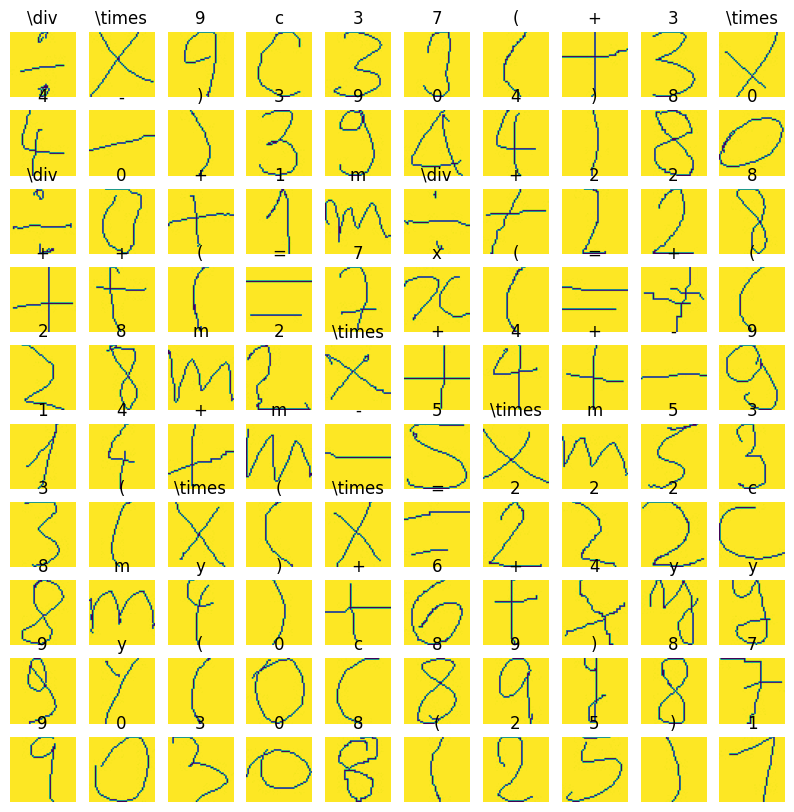

In [14]:
from sklearn.metrics import accuracy_score
import random

# score = model.evaluate(x_test, y_test_cat, verbose=0)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

#testing match between data and labels
plt.figure(figsize=(10, 10))

n=100
plt.figure(figsize=(10, 10))
random_int = random.randint(1, 50000)

for i in range(0, n):
    ax = plt.subplot(10, 10, i + 1)
    
    y_pred = model.predict(tf.expand_dims(x_test[i], axis=0))
    plt.imshow(x_test[i])
    plt.title(numsToLatex[y_pred.argmax(axis=-1)[0]])
    plt.axis('off')
    




In [36]:
model.save(r'C:\Users\Benjamin\Projects\NEA\models.keras')